# Data Center Energy Analysis

The core problem is to understand and predict the power consumption of individual servers within a data center. This is a significant challenge for data center operators aiming to optimize energy usage, manage thermal loads, and plan capacity. Power consumption isn't static; it's influenced by a variety of factors including the physical location of a server (which might correlate with cooling efficiency or proximity to power distribution units), the type of computational job it's currently running (e.g., CPU-intensive tasks vs. idle states), and inherent server characteristics like age or firmware.

Furthermore, data center operations often exhibit temporal patterns. For instance, workloads might be higher during business hours or specific days of the week, leading to fluctuations in power demand. 

The machine learning workflow aims to model these complex relationships by, 
1. Generating synthetic data that mimics these characteristics, 
2. Preprocessing this data to ensure it's suitable for analysis, which includes handling missing values, normalizing features, and encoding categorical variables,
3. Training a predictive model (like a Random Forest Regressor),
4. And interpreting the model's findings to identify which factors are most influential in determining server power usage, including visualizing spatial and time-based trends.

In [1]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## Load Data Center Dataset

The `generate_server_data_timeseries` function in the Python script is designed to create a synthetic dataset that mimics the operational data you might find for servers in a data center over a period.

The output of this function is a **pandas DataFrame**. Each row in this DataFrame represents a single data point for a specific server at a particular hour over several simulated days.

Here's a breakdown of what each column in the output DataFrame signifies:

* **`server_id`**: A unique string identifier for each server (e.g., "server_001").

* **`timestamp`**: A datetime object indicating the specific date and hour for that data record.

* **`x_position`**: An integer representing the **row number** where the server is physically located in the data center layout.

* **`y_position`**: An integer representing the **column number** where the server is physically located.

* **`job_type`**: A string indicating the type of computational workload the server is handling at that specific timestamp (e.g., 'CPU_intensive', 'IO_intensive', 'Idle'). The job type for a server can change over the simulated time.

* **`server_age_days`**: An integer representing the age of the server in days at that point in time. This value increases as the simulation progresses.

* **`last_maintenance_days_ago`**: An integer indicating how many days have passed since the server's last simulated maintenance. This also increases over time.

* **`firmware_version`**: A string representing the firmware version of the server. In this simulation, it's static for each server.

* **`rack_temperature_celsius`**: A floating-point number representing the simulated ambient temperature of the server rack in Celsius. This value has a simulated daily and weekly cyclical pattern with some added noise.

* **`power_consumption_kw`**: This is the primary target variable you'd want to predict. It's a floating-point number representing the server's power consumption in kilowatts (kW) at that specific timestamp. The value is calculated based on a combination of the server's job type, its x/y position, a general time-of-day effect, and some random noise.

Essentially, the function generates a table where you can see, for each server, how its characteristics (like job type, age, temperature) and its power consumption evolve hourly over the simulated period. The function also intentionally introduces a small number of missing values (NaNs) into some of these columns to simulate real-world data imperfections, which the subsequent preprocessing steps in the workflow are designed to handle.

### Generate the Data Center dataset and make one simple plot
```python
import pandas as pd
import matplotlib.pyplot as plt

from utils import generate_data

# Generate the synthetic data
data = generate_data()
# Display the first few rows of the dataset
print(data.head())
# Plot the power consumption of the first server over time

# Load the dataset
dataset = generate_data()

# Display the first few rows of the dataset
print(data.head())

# Plotting power consumption over time for a specific server
server_id = 'server_001'
server_data = data[data['server_id'] == server_id]

plt.figure(figsize=(12, 6))
plt.plot(server_data['timestamp'], server_data['power_consumption_kw'], marker='o')
plt.title(f'Power Consumption Over Time for {server_id}')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [2]:
from utils import generate_data
dataset = generate_data()

2025-06-03 09:56:12,955 - INFO - --- Time-Series Data Generation Complete ---


2025-06-03 09:56:12,956 - INFO - Generated 8400 records (50 servers, 168 timesteps each).


2025-06-03 09:56:12,956 - INFO - Columns: ['server_id', 'timestamp', 'x_position', 'y_position', 'job_type', 'server_age_days', 'last_maintenance_days_ago', 'firmware_version', 'rack_temperature_celsius', 'power_consumption_kw']


2025-06-03 09:56:12,962 - INFO - Sample data:
    server_id           timestamp  x_position  y_position       job_type  \
0  server_001 2024-01-01 00:00:00   37.454012   95.071431  CPU_intensive   
1  server_001 2024-01-01 01:00:00   37.454012   95.071431  CPU_intensive   
2  server_001 2024-01-01 02:00:00   37.454012   95.071431  CPU_intensive   
3  server_001 2024-01-01 03:00:00   37.454012   95.071431  CPU_intensive   
4  server_001 2024-01-01 04:00:00   37.454012   95.071431  CPU_intensive   

   server_age_days  last_maintenance_days_ago firmware_version  \
0           1160.0                         71      v2.0.0_beta   
1           1160.0                         71      v2.0.0_beta   
2           1160.0                         71      v2.0.0_beta   
3           1160.0                         71      v2.0.0_beta   
4           1160.0                         71      v2.0.0_beta   

   rack_temperature_celsius  power_consumption_kw  
0                       NaN              0.22896

In [3]:
dataset

,server_id,timestamp,x_position,y_position,job_type,server_age_days,last_maintenance_days_ago,firmware_version,rack_temperature_celsius,power_consumption_kw
0,server_001,2024-01-01 00:00:00,37.454012,95.071431,CPU_intensive,1160.0,71,v2.0.0_beta,NaN,0.228967
1,server_001,2024-01-01 01:00:00,37.454012,95.071431,CPU_intensive,1160.0,71,v2.0.0_beta,17.854253,0.263216
2,server_001,2024-01-01 02:00:00,37.454012,95.071431,CPU_intensive,1160.0,71,v2.0.0_beta,19.165728,0.210511
3,server_001,2024-01-01 03:00:00,37.454012,95.071431,CPU_intensive,1160.0,71,v2.0.0_beta,21.324186,0.226486
4,server_001,2024-01-01 04:00:00,37.454012,95.071431,CPU_intensive,1160.0,71,v2.0.0_beta,20.220519,0.224661
...,...,...,...,...,...,...,...,...,...,...
8395,server_050,2024-01-07 19:00:00,16.080805,54.873379,IO_intensive,857.0,168,v2.1.5,15.000000,0.142799
8396,server_050,2024-01-07 20:00:00,16.080805,54.873379,IO_intensive,857.0,168,v2.1.5,15.000000,0.154587
8397,server_050,2024-01-07 21:00:00,16.080805,54.873379,IO_intensive,857.0,168,v2.1.5,15.000000,0.121639
8398,server_050,2024-01-07 22:00:00,16.080805,54.873379,IO_intensive,857.0,168,v2.1.5,15.000000,0.125452


## Data Preprocessing and Cleaning

Write a Python function, let's call it **`preprocess_data`**, that takes a raw pandas DataFrame containing data center dataset above and prepares it for a machine learning model aimed at predicting power consumption.

**Interview Task: Data Preprocessing for Server Power Consumption Prediction**

**Input:**
The function will receive a pandas DataFrame. Assume this DataFrame has columns similar to the following (though you should make your function flexible to column names if possible, or clearly state assumptions):

* `server_id` (string, identifier)

* `timestamp` (datetime object)

* `x_position` (integer, server row location)

* `y_position` (integer, server column location)

* `job_type` (string, categorical)

* `server_age_days` (integer)

* `last_maintenance_days_ago` (integer)

* `firmware_version` (string, categorical)

* `rack_temperature_celsius` (float)

* `power_consumption_kw` (float, this will be the target variable)

* *(Assume some columns might contain missing values.)*

**Requirements for the `preprocess_data` function:**

1. **Feature Engineering:**

   * From the `timestamp` column, extract the following new features:

     * `hour_of_day`

     * `day_of_week` (e.g., Monday=0, Sunday=6)

     * `day_of_month`

     * `month`

2. **Feature and Target Separation:**

   * Separate the DataFrame into features (`X`) and the target variable (`y`). The target variable is `power_consumption_kw`.

   * The original `timestamp` and `server_id` columns should not be part of the features `X` fed into the model.

3. **Feature Type Identification:**

   * Identify numerical features (e.g., `x_position`, `y_position`, `server_age_days`, `rack_temperature_celsius`, and the newly engineered time features).

   * Identify categorical features (e.g., `job_type`, `firmware_version`).

4. **Preprocessing Pipeline Construction:**

   * Implement robust preprocessing for both numerical and categorical features, optionally using scikit-learn's `Pipeline` and `ColumnTransformer`.

   * **Numerical Features:**

     * Impute missing values using the median strategy.

     * Scale the features using `StandardScaler`.

   * **Categorical Features:**

     * Impute missing values using the most frequent strategy.

     * Encode the features using `OneHotEncoder`. Ensure it can handle unknown categories encountered during test time (e.g., by ignoring them).

5. **Data Splitting:**

   * Split the processed features and the target variable into training and testing sets. Use a 80/20 split (80% for training, 20% for testing).

   * Ensure the split is reproducible (e.g., by using a fixed `random_state`).

**Output:**
The function should return:

* `X_train`: Training features.

* `X_test`: Testing features.

* `y_train`: Training target.

* `y_test`: Testing target.

* `preprocessor`: The fitted `ColumnTransformer` object used for all preprocessing steps.

* A list of numerical feature names (after engineering, before transformation).

* A list of categorical feature names (before transformation).

**Bonus:**

* Explain the benefits of using `Pipeline` and `ColumnTransformer`.

```python
def preprocess_data(dataset):
    """
    Preprocesses the time-series server data.
    Extracts time features.
    """

    # Feature Engineering: Extract time components *before* dropping columns
    dataset['hour_of_day'] = dataset['timestamp'].dt.
    ...


    # Define features (X) and target (y) *after* adding time features
    # server_id and original timestamp might be dropped or handled differently depending on model
    X = ...
    y = ...

    numerical_features = ...
    categorical_features = ...

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', ...)
    ])

    categorical_pipeline = Pipeline([
        ('imputer', ...),
        ('onehot', ...)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='passthrough' # e.g. if we decide to keep server_id (encoded) for some reason
    )

    # Using random split for now. For true time-series forecasting, a chronological split is better.
    X_train, X_test, y_train, y_test = ...

    logger.info(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    logger.info("Missing values before preprocessing (training set sample):")
    logger.info(X_train.isnull().sum().head())

    logger.info("Preprocessing setup complete.\n")
    # Return the original dataframe WITH the new time features for visualization/interpretation
    return dataset, X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features

In [4]:
from utils import preprocess_data
dataset_processed, X_train, X_test, y_train, y_test, preprocessor_pipeline, num_feats, cat_feats_orig = preprocess_data(dataset.copy())

2025-06-03 09:56:13,036 - INFO - X_train shape: (6720, 11), X_test shape: (1680, 11)


2025-06-03 09:56:13,037 - INFO - Missing values before preprocessing (training set sample):


2025-06-03 09:56:13,039 - INFO - x_position                    0
y_position                    0
job_type                     65
server_age_days              71
last_maintenance_days_ago     0
dtype: int64


2025-06-03 09:56:13,040 - INFO - Preprocessing setup complete.



## Model Training and Evaluation

Write a Python function, let's call it `train_and_evaluate_model`, that takes preprocessed training and testing data, along with a pre-fitted preprocessor object, to train a regression model and evaluate its performance in predicting server power consumption.

**Context:**
This function is a part of a larger machine learning workflow. You will receive data that has already been split into training and testing sets, and a preprocessor (e.g., a scikit-learn `ColumnTransformer`) that has been fitted on the training data.

**Inputs:**
The function `train_and_evaluate_model` should accept the following arguments:

* `X_train`: A pandas DataFrame or NumPy array of training features (these features are *before* the preprocessor in the pipeline is applied).

* `X_test`: A pandas DataFrame or NumPy array of testing features (similarly, *before* the preprocessor is applied).

* `y_train`: A pandas Series or NumPy array of the target variable (power consumption) for the training set.

* `y_test`: A pandas Series or NumPy array of the target variable for the testing set.

* `preprocessor`: A pre-fitted scikit-learn preprocessor object (e.g., `ColumnTransformer`) that handles transformations like scaling, encoding, and imputation.

**Requirements for the `train_and_evaluate_model` function:**

1. **Pipeline Construction:**

   * Create a scikit-learn `Pipeline` that includes two main steps:

     * The provided `preprocessor` object as the first step.

     * A `RandomForestRegressor` model as the second step.

   * Configure the `RandomForestRegressor` with the following parameters (or sensible defaults if you prefer, but state them clearly):

     * `n_estimators=100`

     * `random_state=42` (for reproducibility)

     * `oob_score=True` (to enable Out-of-Bag score calculation)

     * `n_jobs=-1` (to use all available CPU cores)

     * Consider adding parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` to control tree complexity and prevent overfitting (e.g., `max_depth=15`, `min_samples_split=10`, `min_samples_leaf=5`).

2. **Model Training:**

   * Train the entire pipeline using the `X_train` (raw training features) and `y_train` data. The pipeline will internally handle the preprocessing of `X_train`.

3. **Model Evaluation:**

   * **Out-of-Bag (OOB) Score:** If `oob_score=True` was used for the `RandomForestRegressor`, retrieve and print the OOB R² score from the trained regressor step within the pipeline.

   * **Test Set Predictions:** Use the trained pipeline to make predictions on the `X_test` data (raw testing features). The pipeline will internally handle the preprocessing of `X_test`.

   * **Performance Metrics:** Calculate and print the following metrics using `y_test` (actual values) and the predictions made on `X_test`:

     * Mean Squared Error (MSE).

     * R-squared (R²) Score.

**Output:**
The function should return:

* `model`: The fully trained scikit-learn `Pipeline` object (containing both the preprocessor and the regressor).

* `y_pred`: The predictions made by the model on the `X_test` data.

**Bonus Discussion Points:**

* Why is it important to include the `preprocessor` in the pipeline when making predictions on the test set, rather than preprocessing `X_test` separately before prediction?

* What is the Out-of-Bag score, and why is it useful as an evaluation metric?

* If you were to tune the hyperparameters for the `RandomForestRegressor` (e.g., `n_estimators`, `max_depth`), how would you approach this? (Mention techniques like GridSearchCV or RandomizedSearchCV and how they would interact with the pipeline).

* What are some alternative regression models you might consider for this problem, and what are their potential advantages or disadvantages compared to Random Forest in this context?

```python
def train_and_evaluate_model(X_train, X_test, y_train, y_test, preprocessor):
    
    model = Pipeline([... # Adjusted params slightly
    ])
    logger.info("Training the RandomForestRegressor model...")
    model.fit(...)
    logger.info("Model training complete.")

    if hasattr(model.named_steps['regressor'], 'oob_score_') and model.named_steps['regressor'].oob_score_:
         logger.info(f"Out-of-Bag R^2 score: {model.named_steps['regressor'].oob_score_:.4f}")

    ... # Make predictions on the test set

    logger.info(f"\nModel Performance on Test Set:")
    logger.info(f"Mean Squared Error (MSE): {mse:.4f}")
    logger.info(f"R-squared (R2) Score: {r2:.4f}\n")
    return model, y_pred

In [5]:
from utils import train_and_evaluate_model
trained_model, y_predictions = train_and_evaluate_model(X_train, X_test, y_train, y_test, preprocessor_pipeline)


2025-06-03 09:56:13,059 - INFO - Training the RandomForestRegressor model...


2025-06-03 09:56:13,491 - INFO - Model training complete.


2025-06-03 09:56:13,494 - INFO - Out-of-Bag R^2 score: 0.9318


2025-06-03 09:56:13,531 - INFO - 
Model Performance on Test Set:


2025-06-03 09:56:13,532 - INFO - Mean Squared Error (MSE): 0.0003


2025-06-03 09:56:13,532 - INFO - R-squared (R2) Score: 0.9177



## Interview Task: Model Interpretation and Data Discovery for Server Power Consumption**

**Problem Statement:**
Write a Python function, let's call it `interpret_model`, that takes a trained machine learning model pipeline, the original dataset, and lists of feature names to perform model interpretation and data discovery. The goal is to extract insights about what drives server power consumption and to visualize key trends.

**Context:**
Assume you have already trained a scikit-learn pipeline (containing a preprocessor and a regressor like `RandomForestRegressor`) to predict `power_consumption_kw`. You also have access to the original, untransformed DataFrame and the names of the features used.

**Inputs:**
The function `interpret_model` should accept the following arguments:

* `model_pipeline`: The trained scikit-learn `Pipeline` object (which includes a preprocessor step and a regressor step, e.g., `RandomForestRegressor`).

* `df_original`: The original pandas DataFrame containing all data, including `timestamp`, `server_id`, `x_position` (row), `y_position` (column), `power_consumption_kw`, and all other raw features.

* `numerical_feature_names`: A list of strings representing the names of the numerical features *after* any time-based feature engineering (e.g., `['x_position', 'hour_of_day', 'rack_temperature_celsius', ...]`) but *before* scaling or imputation by the preprocessor.

* `categorical_feature_names_original`: A list of strings representing the names of the original categorical features (e.g., `['job_type', 'firmware_version']`) *before* one-hot encoding by the preprocessor.

**Requirements for the `interpret_model` function:**

1. **Feature Importance Analysis:**

   * Extract feature importances from the regressor step of the `model_pipeline`.

   * Correctly map these importances to their corresponding feature names. This requires accessing the fitted preprocessor within the pipeline to get the names of one-hot encoded categorical features.

   * Print a DataFrame or a sorted list of the top N (e.g., top 20) feature importances.

   * Generate and save a bar plot visualizing these top N feature importances.

2. **Correlation Analysis:**

   * Using the `df_original` DataFrame, calculate the correlation matrix between all features listed in `numerical_feature_names` and the target variable (`power_consumption_kw`).

   * Print this correlation matrix.

   * Generate and save a heatmap visualization of this correlation matrix.

3. **Time-Series Visualization:**

   * Select a single, sample `server_id` from `df_original`.

   * Generate and save a line plot showing its `power_consumption_kw` over the `timestamp`.

4. **Spatial Power Consumption Heatmap & Contours:**

   * From `df_original`, calculate the average `power_consumption_kw` for each unique server location (defined by `x_position` and `y_position`).

   * Generate and save a 2D heatmap (e.g., using `matplotlib.pyplot.tricontourf` or a similar method suitable for potentially irregularly spaced data if not on a perfect grid) that visualizes this average power consumption across the X-Y plane of server locations.

   * Overlay contour lines on the heatmap.

   * Optionally, scatter plot the actual server locations on top of the heatmap.

   * Ensure axes are labeled appropriately (e.g., "X Position (Row)", "Y Position (Column)").

**Output:**
The function should primarily produce printouts of the analyses (feature importances, correlation matrix) and save the generated plots to files (e.g., "feature_importances.png", "correlation_heatmap.png", "sample_server_power_trend.png", "spatial_power_heatmap.png"). It does not need to return any specific Python objects, though returning a dictionary of generated artifacts (like DataFrames or plot objects) could be an extension.

**Bonus Discussion Points:**

* How can the insights from feature importances be used to guide business decisions or further model improvements?

* What are the limitations of relying solely on feature importances from a tree-based model like Random Forest?

* What other types of plots or analyses could be performed on `df_original` to discover more patterns related to server power consumption (e.g., box plots of power by `job_type`)?

* If the server locations (`x_position`, `y_position`) formed a regular grid, how might your approach to generating the spatial heatmap change?

* How would you handle a situation where the number of one-hot encoded features becomes very large when extracting feature importances?

```python
def interpret_model(model, df_with_time_features, numerical_features, categorical_features_original):
    preprocessor_fitted = model.named_steps['preprocessor']
    onehot_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']

    # Numerical features names are direct from the input list
    num_feat_names = numerical_features

    # Categorical features names come from one-hot encoder
    cat_feat_names_onehot = ...

    all_feature_names_transformed = num_feat_names + cat_feat_names_onehot

    importances = ... # Extract feature importances from the regressor step

    feature_importance_df = pd.DataFrame({'feature': all_feature_names_transformed, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(...)

    logger.info("Feature Importances:")
    logger.info(feature_importance_df.head(20)) # Show more features

    # Save feature importance plot
    plt.figure(figsize=(12, 10))
    ...
    plt.title('Top Feature Importances (Time-Series Model)')
    plt.tight_layout()
    plt.savefig("feature_importances_timeseries.png")
    logger.info("\nFeature importance plot saved as feature_importances_timeseries.png")

    # Correlation Matrix (on original numerical + engineered time features)
    logger.info("\nCorrelation Matrix (Numerical & Time Features vs Target):")
    # Use the dataframe that already has the time features
    cols_for_corr = numerical_features + ['power_consumption_kw']
    df_for_corr = df_with_time_features[cols_for_corr].copy()
    df_for_corr.dropna(inplace=True)

    if not df_for_corr.empty and len(df_for_corr.columns) > 1:
        correlation_matrix = ...
        plt.figure(figsize=(12, 10))
        ...
        plt.title('Correlation Matrix (Numerical & Time Features and Target)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig("correlation_matrix_timeseries.png")
        logger.info("\nCorrelation matrix plot saved as correlation_matrix_timeseries.png")
    else:
        logger.info("Not enough data for correlation matrix.")

    # Plot power consumption over time for a sample server
    # Use the dataframe that already has the time features
    sample_server_id = df_with_time_features['server_id'].unique()[0]
    sample_server_data = df_with_time_features[df_with_time_features['server_id'] == sample_server_id].copy()

    plt.figure(figsize=(15, 6))
    ...
    plt.title(f'Power Consumption Over Time for {sample_server_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (kW)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("power_over_time_sample_server.png")
    logger.info(f"\nPower over time plot for {sample_server_id} saved as power_over_time_sample_server.png")


2025-06-03 09:56:13,572 - INFO - Feature Importances:


2025-06-03 09:56:13,573 - INFO -                          feature  importance
11                 job_type_Idle    0.784919
10         job_type_IO_intensive    0.072289
9         job_type_CPU_intensive    0.041128
5                    hour_of_day    0.030519
0                     x_position    0.028205
1                     y_position    0.008160
4       rack_temperature_celsius    0.006012
2                server_age_days    0.005158
13           job_type_Mixed_load    0.004962
7                   day_of_month    0.004707
6                    day_of_week    0.004632
3      last_maintenance_days_ago    0.004611
12     job_type_Memory_intensive    0.003263
14       firmware_version_v1.0.1    0.000388
15       firmware_version_v1.2.3    0.000387
17       firmware_version_v2.1.5    0.000291
16  firmware_version_v2.0.0_beta    0.000212
18       firmware_version_v2.2.0    0.000157
8                          month    0.000000


2025-06-03 09:56:13,869 - INFO - 
Feature importance plot saved as feature_importances_timeseries.png


2025-06-03 09:56:13,870 - INFO - 
Correlation Matrix (Numerical & Time Features vs Target):


2025-06-03 09:56:14,253 - INFO - 
Correlation matrix plot saved as correlation_matrix_timeseries.png


2025-06-03 09:56:14,453 - INFO - 
Power over time plot for server_001 saved as power_over_time_sample_server.png


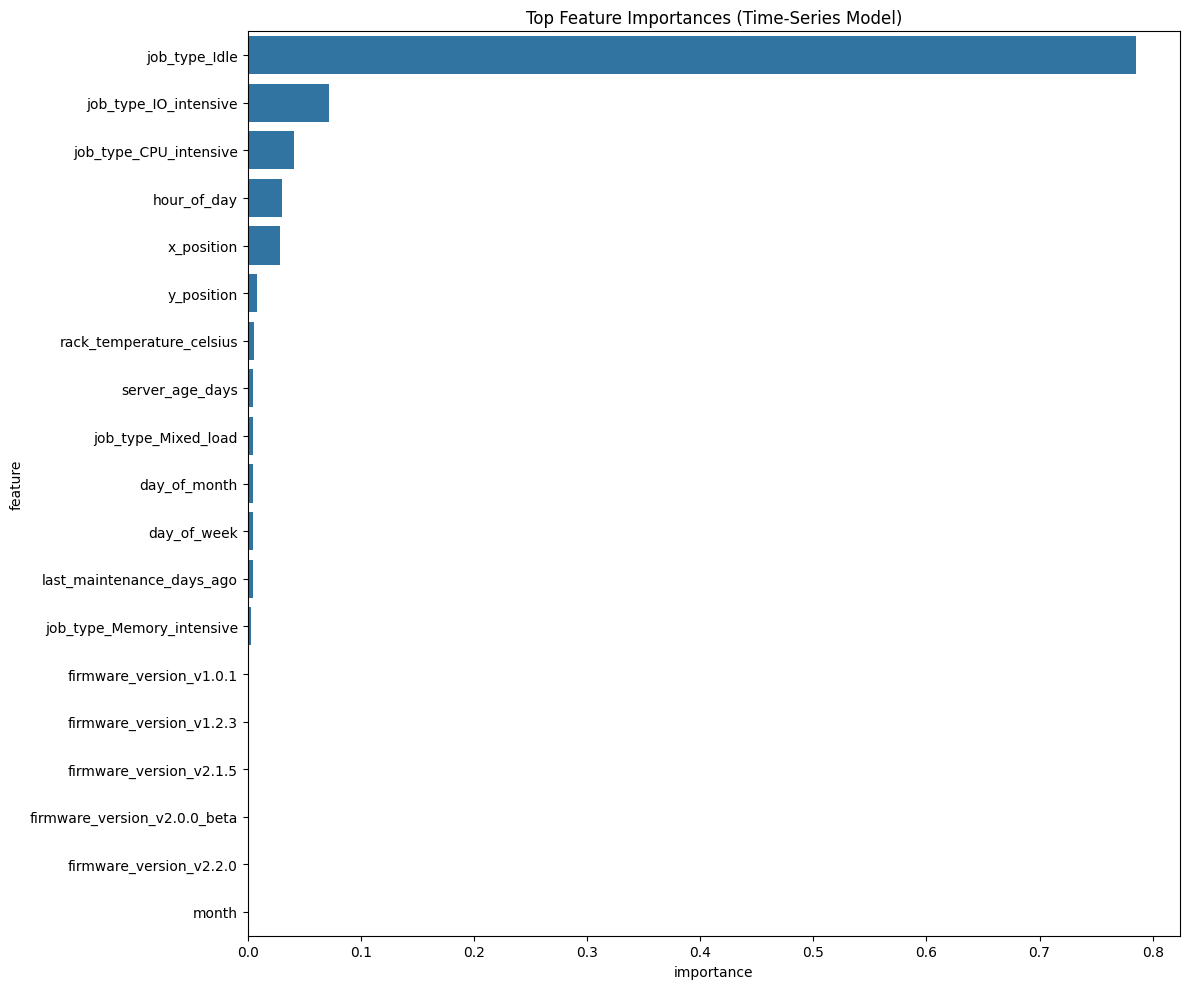

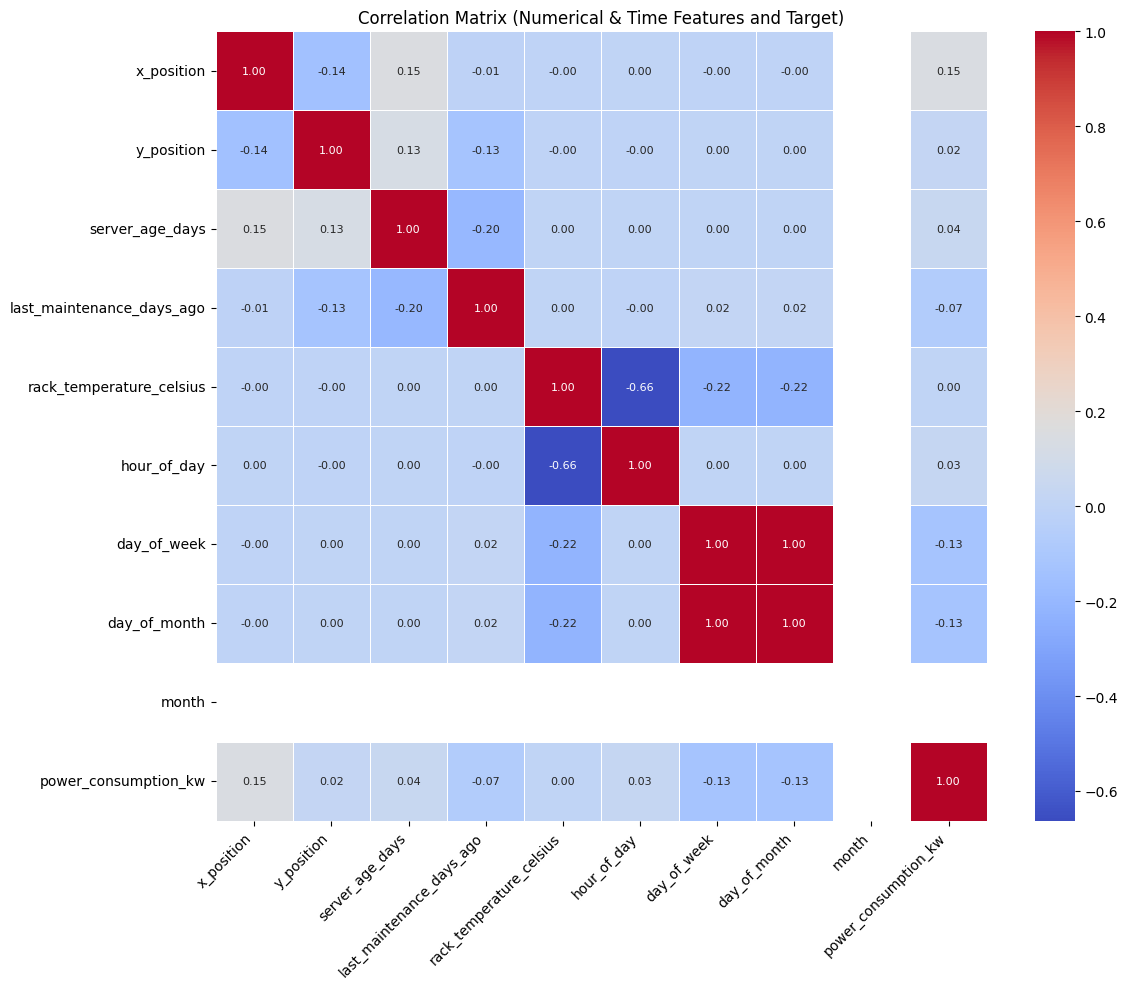

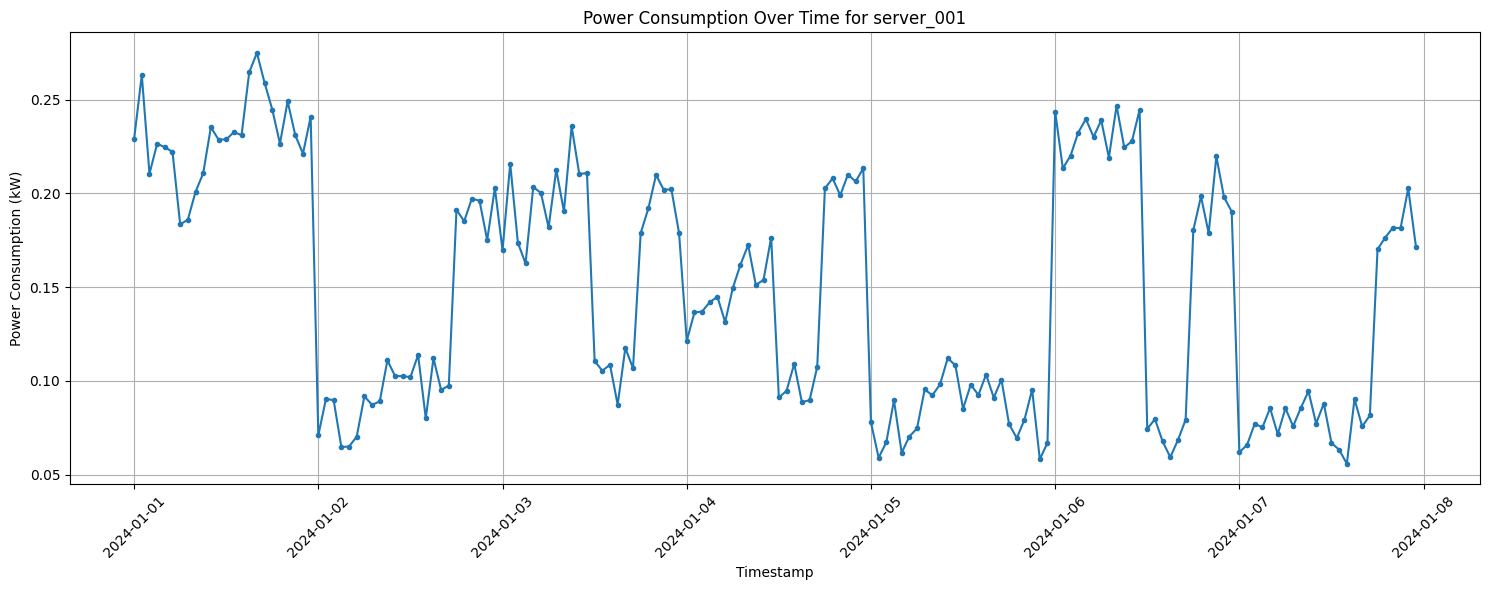

In [6]:
from utils import interpret_model
interpret_model(trained_model, dataset_processed, num_feats, cat_feats_orig)

2025-06-03 09:56:15,160 - INFO - 
Actual vs. Predicted plot saved as actual_vs_predicted_timeseries.png


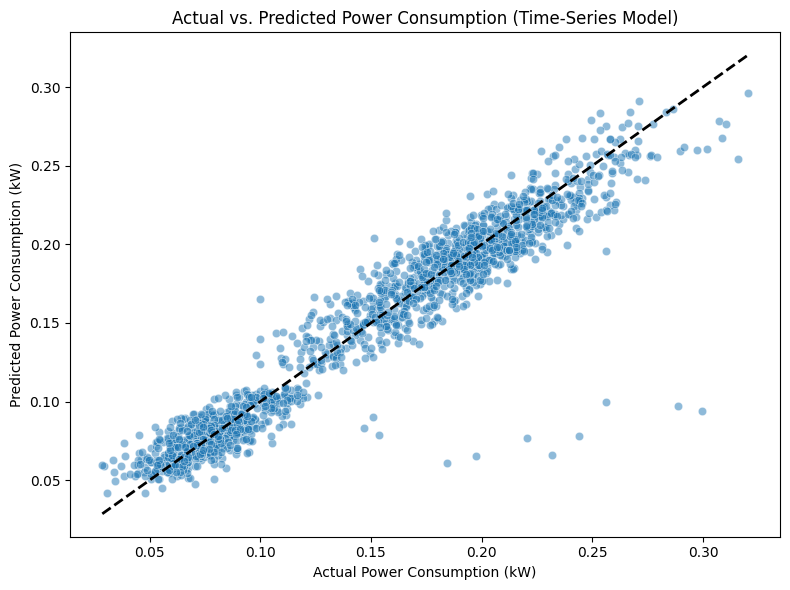

In [7]:
# Plot Actual vs. Predicted

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predictions, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Power Consumption (kW)')
plt.ylabel('Predicted Power Consumption (kW)')
plt.title('Actual vs. Predicted Power Consumption (Time-Series Model)')
plt.tight_layout()
plt.savefig("actual_vs_predicted_timeseries.png")
logger.info("\nActual vs. Predicted plot saved as actual_vs_predicted_timeseries.png")